# Natural Language Processing - Public Opinion on Climate Change 

## 1. Sentiment Analysis with nltk and TextBlob

In this notebook we will do the sentiment analysis with TextBlob. TextBlob's sentiment analysis uses a simple rule-based approach. It uses predefined lists of positive and negative words to determine the sentiment polarity.

### Import relevant libraries and data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os

import nltk
# Download the stopwords data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import re

from textblob import TextBlob

from collections import Counter

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/claudia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/claudia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import data
df_original = pd.read_csv('../data/df_posts.csv')
df = df_original.copy()
df = df[~(df.year.isna())]
df.year = df['year'].astype(int)
df.head()

/tmp/ipykernel_2908793/3770064288.py:2: DtypeWarning: Columns (1,8,9,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('../data/df_posts.csv')


comment_id score                                          self_text  \
0    lds45dg     1  At no point in the Milankovich cycle should th...   
1    lds42w7     1  &gt; So, I have to ask: how can Americans crit...   
2    lds3yu1     1  Because they are paid handsomely by fossil fue...   
3    lds3y2w     1  Depends on your house, they want £4k for mine ...   
4    lds3u4b     1  This is what happens when people face conseque...   

       subreddit         created_time  post_id  controversiality  ups downs  \
0       politics  2024-07-18 14:59:21  1e6bs6r               0.0  1.0     0   
1   changemyview  2024-07-18 14:58:59  1e6day6               0.0  1.0     0   
2         energy  2024-07-18 14:58:22  1e5luu1               0.0  1.0     0   
3  unitedkingdom  2024-07-18 14:58:16  1e6c2xf               0.0  1.0     0   
4        climate  2024-07-18 14:57:39  1e5yxqk               0.0  1.0     0   

  post_score                                     post_self_text  \
0         88                                                NaN   
1          0  As an African, I've spent quite some time expl...   
2       1531  Has anyone else watching the convention gotten...   
3          4                                                NaN   
4        527                                                NaN   

                                          post_title  post_upvote_ratio  \
0  123 House and Senate Republicans deny climate ...               0.93   
1  CMV: The USA has lost its moral high ground in...               0.22   
2  Why does the RNC seem to think we don’t produc...               0.91   
3  Climate body CCC says cut electricity bills to...               0.83   
4  Texas residents endure days-long heat wave and...               0.99   

  post_thumbs_ups post_total_awards_received    post_created_time  \
0              88                          0  2024-07-18 13:43:35   
1               0                          0  2024-07-18 14:49:24   
2            1531                          0  2024-07-17 16:01:11   
3               4                          0  2024-07-18 13:57:00   
4             527                          0  2024-07-18 01:11:19   

                                          clean_text  \
0  point milankovich cycle earth warm multiple de...   
1  ask american criticize african leader politica...   
2     paid handsomely fossil fuel interest say thing   
3  depends house want 4k mine grant modern house ...   
4  happens people face consequence blame wrong pe...   

                                clean_post_self_text  \
0                                                NaN   
1  african ive spent quite time exploring various...   
2  anyone else watching convention gotten impress...   
3                                                NaN   
4                                                NaN   

                                         clean_title  year  
0  123 house senate republican deny climate scien...  2024  
1  cmv usa lost moral high ground criticizing afr...  2024  
2      rnc seem think dont produce oil gas u anymore  2024  
3  climate body ccc say cut electricity bill boos...  2024  
4     texas resident endure dayslong heat wave power  2024

We will add a list of climate related keywords to further filter our titles, posts to make sure these discuss climate related topics. We also will remove all conspiracy posts. 

For the list of climate related keywords we refer to the list of keywords used in the article *"Sentiment analysis on Twitter data towards climate action"* by Emelie Rosenberg, Carlota Tarazona, Fermín Mallor, Hamidreza Eivazi, David Pastor-Escuredo, Francesco Fuso-Nerini, Ricardo Vinuesa

In [3]:
# Import key words to filter post by climate related topics
climate_key_words = pd.read_csv('../data/climate_key_words.csv')

key_words_list = climate_key_words.loc[0:2, "key_words"].apply(lambda x: str(x).strip().split(","))
key_words_list = pd.DataFrame(key_words_list)

# Explode the 'key_words' column and convert to a list
key_words_list = key_words_list['key_words'].explode()

# Clean up key words
key_words_list = key_words_list.str.strip().str.lower().tolist()

#we will remove the word 'cop' as it can be also slang word for police
key_words_list.remove('cop')
key_words_list

['affordable energy',
 'energy',
 'reliable energy',
 'modern energy',
 'access to energy',
 'electrification',
 'clean energy',
 'renewable energy',
 'energy efficiency',
 'renewables',
 'energy infrastructure',
 'fossil-fuel technology',
 'clean energy',
 'international cooperation on energy',
 'alternative energy',
 'energy resources',
 'solar energy',
 'photovoltaic',
 'photovoltaics',
 'electrification',
 'bioenergy',
 'biofuel',
 'biofuels',
 'biodiesel',
 'biogasoline',
 'carbon',
 'charcoal',
 'green energy',
 'biomass',
 'woodfuels',
 'sustainable energy',
 'sustainable energy investments',
 'energy developing countries',
 'energy land-locked countries',
 'energy least developed countries.',
 'safe housing',
 'affordable housing',
 'upgrade slums',
 'sustainable transport',
 'sustainable transportation',
 'public transport',
 'city air quality',
 'waste management',
 'sustainable cities and communities',
 'sustainable housing',
 'urbanization',
 'urban environmental impact',
 

In [4]:
df = df[~(df.subreddit == 'conspiracy')]
df.head()

comment_id score                                          self_text  \
0    lds45dg     1  At no point in the Milankovich cycle should th...   
1    lds42w7     1  &gt; So, I have to ask: how can Americans crit...   
2    lds3yu1     1  Because they are paid handsomely by fossil fue...   
3    lds3y2w     1  Depends on your house, they want £4k for mine ...   
4    lds3u4b     1  This is what happens when people face conseque...   

       subreddit         created_time  post_id  controversiality  ups downs  \
0       politics  2024-07-18 14:59:21  1e6bs6r               0.0  1.0     0   
1   changemyview  2024-07-18 14:58:59  1e6day6               0.0  1.0     0   
2         energy  2024-07-18 14:58:22  1e5luu1               0.0  1.0     0   
3  unitedkingdom  2024-07-18 14:58:16  1e6c2xf               0.0  1.0     0   
4        climate  2024-07-18 14:57:39  1e5yxqk               0.0  1.0     0   

  post_score                                     post_self_text  \
0         88                                                NaN   
1          0  As an African, I've spent quite some time expl...   
2       1531  Has anyone else watching the convention gotten...   
3          4                                                NaN   
4        527                                                NaN   

                                          post_title  post_upvote_ratio  \
0  123 House and Senate Republicans deny climate ...               0.93   
1  CMV: The USA has lost its moral high ground in...               0.22   
2  Why does the RNC seem to think we don’t produc...               0.91   
3  Climate body CCC says cut electricity bills to...               0.83   
4  Texas residents endure days-long heat wave and...               0.99   

  post_thumbs_ups post_total_awards_received    post_created_time  \
0              88                          0  2024-07-18 13:43:35   
1               0                          0  2024-07-18 14:49:24   
2            1531                          0  2024-07-17 16:01:11   
3               4                          0  2024-07-18 13:57:00   
4             527                          0  2024-07-18 01:11:19   

                                          clean_text  \
0  point milankovich cycle earth warm multiple de...   
1  ask american criticize african leader politica...   
2     paid handsomely fossil fuel interest say thing   
3  depends house want 4k mine grant modern house ...   
4  happens people face consequence blame wrong pe...   

                                clean_post_self_text  \
0                                                NaN   
1  african ive spent quite time exploring various...   
2  anyone else watching convention gotten impress...   
3                                                NaN   
4                                                NaN   

                                         clean_title  year  
0  123 house senate republican deny climate scien...  2024  
1  cmv usa lost moral high ground criticizing afr...  2024  
2      rnc seem think dont produce oil gas u anymore  2024  
3  climate body ccc say cut electricity bill boos...  2024  
4     texas resident endure dayslong heat wave power  2024

### Sentiment Analysis for Post Titles

In [5]:
df_uniq_titles=df[(~df['post_title'].isna())]
# Remove duplicate values from the 'post_title' column , as the one post may be duplicated as it has many comments
df_uniq_titles = df_uniq_titles.drop_duplicates(subset=['post_title'])
df_uniq_titles.count()

comment_id                    16261
score                         16261
self_text                     16261
subreddit                     16261
created_time                  16261
post_id                       16261
controversiality              16261
ups                           16261
downs                         16261
post_score                    16261
post_self_text                 3987
post_title                    16261
post_upvote_ratio             16261
post_thumbs_ups               16261
post_total_awards_received    16261
post_created_time             16261
clean_text                    16080
clean_post_self_text           3840
clean_title                   16253
year                          16261
dtype: int64

In [6]:
# keeping only comments to climate related_titles
pattern = '|'.join(re.escape(keyword) for keyword in key_words_list)

# Filter posts that match any of the keywords
matching_titles = df_uniq_titles[df_uniq_titles['post_title'].str.contains(pattern, case=False, na=False)]

# Count the filtered DataFrame
print(matching_titles.count())

# Create a new data frame with matching posts
df_climate_titles = pd.DataFrame(matching_titles)
df_climate_titles.head()

comment_id                    6126
score                         6126
self_text                     6126
subreddit                     6126
created_time                  6126
post_id                       6126
controversiality              6126
ups                           6126
downs                         6126
post_score                    6126
post_self_text                1197
post_title                    6126
post_upvote_ratio             6126
post_thumbs_ups               6126
post_total_awards_received    6126
post_created_time             6126
clean_text                    6063
clean_post_self_text          1151
clean_title                   6125
year                          6126
dtype: int64


comment_id score                                          self_text  \
7     lds3oog     1  How much greenhouse gasses get released in war...   
14    lds32x7     1  Is it. Is it really impossible, like Is there ...   
42    lds09zc     1  It does not work like this.\n\nSolar deploymen...   
55    ldrz4s5     1  &gt;And they’re on pace to improve on those mu...   
89    ldrwiy1     1  China knows that if it becomes the leader in g...   

     subreddit         created_time  post_id  controversiality  ups downs  \
7      climate  2024-07-18 14:56:49  1e6d6k6               0.0  1.0     0   
14  Futurology  2024-07-18 14:53:29  1e68oum               0.0  1.0     0   
42      energy  2024-07-18 14:37:54  1e5sntp               0.0  1.0     0   
55      energy  2024-07-18 14:31:28  1e5oxl5               0.0  1.0     0   
89      energy  2024-07-18 14:16:33  1e666b5               0.0  1.0     0   

   post_score post_self_text  \
7           2            NaN   
14        183            NaN   
42        204            NaN   
55        139            NaN   
89         22            NaN   

                                           post_title  post_upvote_ratio  \
7   Why the Era of China’s Soaring Carbon Emission...               1.00   
14  The world's largest renewable energy and trans...               0.95   
42  How the Inflation Reduction Act is playing out...               0.98   
55  China is on track to reach its clean energy ta...               0.92   
89  China to Boost Funding to Reduce Emissions at ...               0.92   

   post_thumbs_ups post_total_awards_received    post_created_time  \
7                2                          0  2024-07-18 14:44:17   
14             183                          0  2024-07-18 11:04:40   
42             204                          0  2024-07-17 20:36:36   
55             139                          0  2024-07-17 18:04:43   
89              22                          0  2024-07-18 08:14:51   

                                           clean_text clean_post_self_text  \
7            much greenhouse gas get released warfare                  NaN   
14  really impossible like physical way could like...                  NaN   
42  work like solar deployment want buy land lease...                  NaN   
55  theyre pace improve much faster country possib...                  NaN   
89  china know becomes leader green energy green p...                  NaN   

                                          clean_title  year  
7   era china soaring carbon emission might ending...  2024  
14  world largest renewable energy transmission pr...  2024  
42  inflation reduction act playing one biased sta...  2024  
55  china track reach clean energy target month si...  2024  
89  china boost funding reduce emission coal power...  2024

In [7]:
# Sentiment score for each title record
df_climate_titles['title_sentiment'] = df_climate_titles['clean_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [8]:
# Assign category for each title record
df_climate_titles['title_sentiment_category'] = df_climate_titles['title_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [9]:
# Count the occurrences of each sentiment category
sentiment_counts = df_climate_titles['title_sentiment_category'].value_counts()
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Title_Sentiment', 'Count']
sentiment_counts_df = sentiment_counts_df.sort_values(by='Count', ascending=False)
sentiment_counts_df

Title_Sentiment  Count
0         Neutral   2652
1        Positive   2304
2        Negative   1170

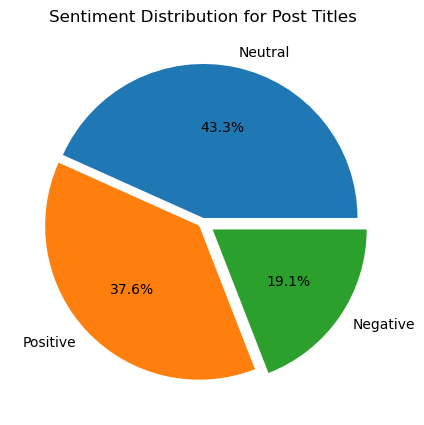

In [10]:
plt.figure(figsize=(5, 5))
ax = plt.pie(x =df_climate_titles['title_sentiment_category'].value_counts() , labels=df_climate_titles['title_sentiment_category'].value_counts().index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Sentiment Distribution for Post Titles')
plt.show()

In [11]:
pd.set_option('display.max_colwidth', None)
print('Example of neutral titles') 
display(df_climate_titles[df_climate_titles.title_sentiment_category == 'Neutral']['post_title'].head(3))

print('----------------------------------------------------------------')
print('Example of positive titles') 
display(df_climate_titles[df_climate_titles.title_sentiment_category == 'Positive']['post_title'].head(3))

print('----------------------------------------------------------------')
print('Example of negative titles') 
pd.set_option('display.max_colwidth', None)
display(df_climate_titles[df_climate_titles.title_sentiment_category == 'Negative']['post_title'].head(3))

Example of neutral titles


14    The world's largest renewable energy and transmission project has received key approval from government officials | The Australia-Asia Power Link project will send Australian solar power to Singapore via 4,300 kilometer-long undersea cables.
42                                       How the Inflation Reduction Act is playing out in one of the ‘most biased’ states for renewables. Solar developers are going head-to-head with fossil fuel-backed opposition groups and renewable bans in Ohio
89                                                                                                                                                                                      China to Boost Funding to Reduce Emissions at Coal Power Plants
Name: post_title, dtype: object

----------------------------------------------------------------
Example of positive titles


7                                                          Why the Era of China’s Soaring Carbon Emissions Might Be Ending | Analysts are seeing promising signs from the world’s biggest emitter of greenhouse gases.
55                                                                                                                         China is on track to reach its clean energy targets this month… six years ahead of schedule
155    'Absolute miracle' breakthrough provides recipe for zero-carbon cement: « Old concrete can be recycled in furnaces used to recycle steel, in a new method that drastically reduces the CO2 emissions of both. »
Name: post_title, dtype: object

----------------------------------------------------------------
Example of negative titles


406                                                         Is Climate Change Making Us Sick? Zoom Q&amp;A with Climate Risk Expert and IPCC climate report contributor Hans-Martin Fuessel (EEA)
544                                                                                            Wrong, Bloomberg, Texas “Deniers” Are Right, Climate Change Had Nothing to Do with Hurricane Beryl
1254    Polar ice melting makes Earth heavier to rotate, causing longer days | A new study reveals that Earth’s spin axis is “shifting” due to climate change and the planet’s internal dynamics.
Name: post_title, dtype: object

As we can see from the titles, sentiment analysis with TextBlob allows to do a basic categorization of neutral titles, positive and negative titles. It does not classify posts according to their controversiality. Maybe our analysis on key words and topics allows us to go into more details. 

Let's look at the distribution of the sentiment categories over the years

In [12]:
grouped_df = df_climate_titles.groupby(['year', 'title_sentiment_category']).agg({'clean_title': 'count'}).reset_index()

In [13]:
pivot_df = grouped_df.pivot(index='year', columns='title_sentiment_category', values='clean_title').fillna('')
pivot_df

title_sentiment_category  Negative  Neutral  Positive
year                                                 
2018                            12       36        30
2019                            33       58        95
2020                            21       51        48
2021                            22       50        62
2022                            61      141       106
2023                           342      841       670
2024                           679     1474      1293

In [14]:
pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
np.round(pivot_df_percent, 2)

title_sentiment_category  Negative  Neutral  Positive
year                                                 
2018                         15.38    46.15     38.46
2019                         17.74    31.18     51.08
2020                         17.50    42.50     40.00
2021                         16.42    37.31     46.27
2022                         19.81    45.78     34.42
2023                         18.46    45.39     36.16
2024                         19.70    42.77     37.52

year
2018    38.461538
2019    51.075269
2020    40.000000
2021    46.268657
2022    34.415584
2023    36.157582
2024    37.521764
Name: Positive, dtype: float64


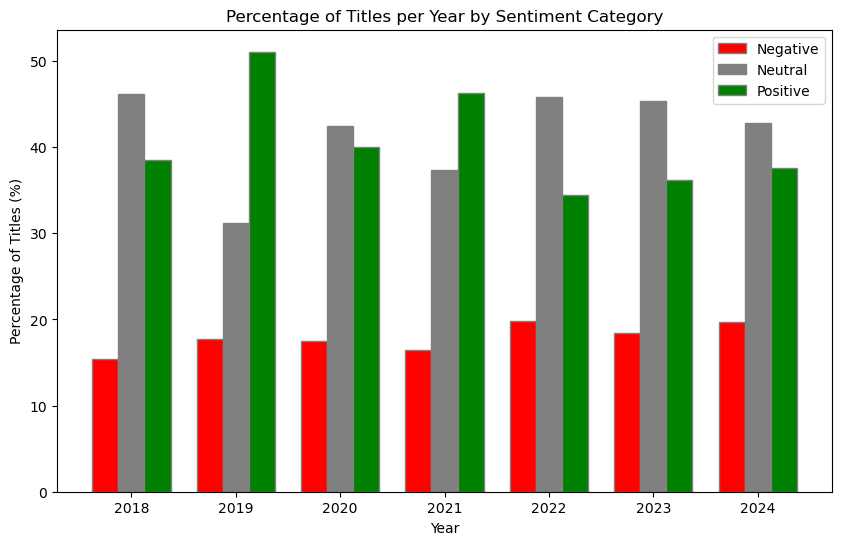

In [15]:
print(pivot_df_percent['Positive'])
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.25
years = pivot_df_percent.index
r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars for each sentiment category
ax.bar(r1, pivot_df_percent['Negative'], color='red', width=bar_width, edgecolor='grey', label='Negative')
ax.bar(r2, pivot_df_percent['Neutral'], color='grey', width=bar_width, edgecolor='grey', label='Neutral')
ax.bar(r3, pivot_df_percent['Positive'], color='green', width=bar_width, edgecolor='grey', label='Positive')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Titles (%)')
ax.set_title('Percentage of Titles per Year by Sentiment Category')
ax.set_xticks([r + bar_width for r in range(len(years))])
ax.set_xticklabels(years)
ax.legend()

plt.show()

The percentage of neutral post titles seems to be slightly decreasing over time while the amount of negative post titles seem to be increasing. Positive titles seem to dominate but never reach over 50%, except in 2019. Just as for neutral post titles, the percentage of positive titles seem to slighlty decrease over time. These trends might indicate increased polarization.  

Let's look at the post texts to see if they follow the same trend.

### Sentiment Analysis for Posts

In [16]:
df_uniq_posts = df[(~df['clean_post_self_text'].isna())]

# Remove duplicate values from the 'post_title' column , as the one post may be duplicated as it has many comments
df_uniq_posts = df_uniq_posts.drop_duplicates(subset=['post_title'])
df_uniq_posts.count()

comment_id                    3882
score                         3882
self_text                     3882
subreddit                     3882
created_time                  3882
post_id                       3882
controversiality              3882
ups                           3882
downs                         3882
post_score                    3882
post_self_text                3882
post_title                    3882
post_upvote_ratio             3882
post_thumbs_ups               3882
post_total_awards_received    3882
post_created_time             3882
clean_text                    3844
clean_post_self_text          3882
clean_title                   3874
year                          3882
dtype: int64

In [17]:
# keeping only comments to climate related_posts
pattern = '|'.join(re.escape(keyword) for keyword in key_words_list)

# Filter posts that match any of the keywords
matching_posts = df_uniq_posts[df_uniq_posts['clean_post_self_text'].str.contains(pattern, case=False, na=False)]

# Count the filtered DataFrame
matching_posts.count()

# Create a new data frame with matching posts
df_climate_posts = pd.DataFrame(matching_posts)
df_climate_posts.count()

comment_id                    2106
score                         2106
self_text                     2106
subreddit                     2106
created_time                  2106
post_id                       2106
controversiality              2106
ups                           2106
downs                         2106
post_score                    2106
post_self_text                2106
post_title                    2106
post_upvote_ratio             2106
post_thumbs_ups               2106
post_total_awards_received    2106
post_created_time             2106
clean_text                    2085
clean_post_self_text          2106
clean_title                   2105
year                          2106
dtype: int64

In [18]:
# Sentiment score for each record
df_climate_posts['post_sentiment'] = df_climate_posts['clean_post_self_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Assign category for each record
df_climate_posts['post_sentiment_category'] = df_climate_posts['post_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))     

# Count the occurrences of each sentiment category
sentiment_counts = df_climate_posts['post_sentiment_category'].value_counts()
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Post_Sentiment', 'Count']
sentiment_counts_df = sentiment_counts_df.sort_values(by='Count', ascending=False)
sentiment_counts_df 

Post_Sentiment  Count
0       Positive   1533
1       Negative    458
2        Neutral    115

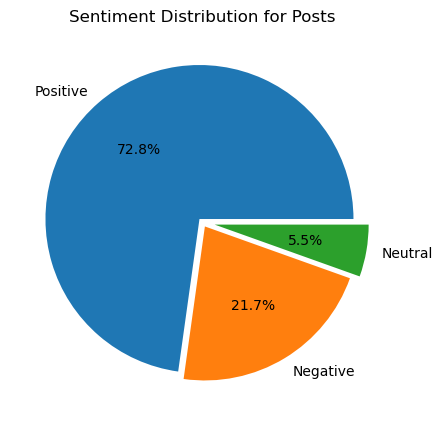

In [19]:
plt.figure(figsize=(5, 5))
ax = plt.pie(x = df_climate_posts['post_sentiment_category'].value_counts() , labels=df_climate_posts['post_sentiment_category'].value_counts().index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Sentiment Distribution for Posts')
plt.show()

In [20]:
pd.set_option('display.max_colwidth', None)
print('Example of neutral posts') 
neutral_posts = df_climate_posts[df_climate_posts.post_sentiment_category == 'Neutral']['post_self_text'].head(3)
display(neutral_posts.to_frame())

print('----------------------------------------------------------------')
print('Example of positive posts') 
positive_posts = df_climate_posts[df_climate_posts.post_sentiment_category == 'Positive']['post_self_text'].head(3)
display(positive_posts.to_frame())

print('----------------------------------------------------------------')
print('Example of negative posts') 
pd.set_option('display.max_colwidth', None)
negative_posts = df_climate_posts[df_climate_posts.post_sentiment_category == 'Negative']['post_self_text'].head(3)
negative_posts.to_frame()

Example of neutral posts


post_self_text
5740   [https://manilastandard.net/tech/tech-news/314471925/filipinos-say-they-have-already-experienced-climate-change-but-are-optimistic-about-future.html](https://manilastandard.net/tech/tech-news/314471925/filipinos-say-they-have-already-experienced-climate-change-but-are-optimistic-about-future.html) 95 percent of Filipino respondents say they are committed to making sustainable choices and practicing more eco-friendly habits to reduce the impact of climate change
12539                                                                                                                                                                                                                                                                                                                                                                                                                             If you believe in climate change, move up in elevation
25591                                                                                                                                                                                                                                                                                                                        could we theoretically split the C molecule from the 2 O then reuse the Carbon as an energy source rather than just freezing CO2 and putting it underground

----------------------------------------------------------------
Example of positive posts


post_self_text
273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     “Environmentalists and fishermen are pushing back against a plan from a group of scientists who want to dump more than 60,000 gallons of sodium hydroxide, more commonly known as lye, into the ocean off Cape Cod to gain an understanding of how to slow climate change.”\n\nThey want to dump lye near Martha’s Vineyard (in a busy fishing zone).  If I’m understanding the article correctly I think they want to reduce the alkalinity of the ocean so that the ocean can absorb more carbon dioxide.\n\nI’m really not understanding how this would work large-scale or why this is a good idea.  Maybe someone here understands it better.
488  I know this might not sit well with many, but if Trump wins the next election, it won't be because of his personality or charisma. He is a vile disgusting human being. It will be because of his policies. There's a pervasive notion among Democrats that Trump supporters are irrational or even lunatics, but that misses a crucial point: many Americans find Trump's policies appealing.\n\nThere's a dismissiveness from the Democratic side that borders on dehumanizing Trump supporters, as if they are less than human for their political choices. This is especially true for the rural poor, who have felt neglected for years. Despite being in power, I don't think the Biden administration has made significant strides in addressing their issues.\n\nMoreover, the Democrats often fail to communicate what their policies are effectively. It feels like they are more focused on retaining power rather than offering concrete solutions. This lack of clear messaging and tangible policies makes it easier for Trump’s straightforward, if controversial, policies to resonate with a significant portion of the population.\n\nSo, if Trump does win, it won't be because of his antics or personality quirks. It will b

----------------------------------------------------------------
Example of negative posts


post_self_text
2                                                                                                                                                                                                                                                                                                             Has anyone else watching the convention gotten the impression that Republicans think we’ve stopped all drilling and aren’t you know, the largest hydrocarbon producing nation on earth?\n\nThey keep going on about drill baby drill like the government and not Capital discipline/price sensitivity is the limit on production. Have none of the people from Texas, Pennsylvania or the Dakotas told them?\n\n  \nI’m also confused about all the hate towards electric cars considering its an area where the US has a clear competitive advantage and Elon musk is pledging $45MM a month (which is nuts), but I guess they like German and Japanese cars more because they’re patriots.
5   Not trying to nitpick the mods or anything, but this byline:\n\n&gt;A place for a rational discussion on a divisive topic\n\nis misleading, in that nothing about the topic itself is inherently divisive. The definition of divisive is: \n\n&gt;tending to cause disagreement or hostility between people\n\nwhich ascribes acrimony around the subject to the subject itself. One might argue that this word is *often* used as a way to be polite about subjects that some people are going to scream at you about if you bring it up, but if so, that just means that we should *often* avoid it if we want to speak clearly and truthfully about what is actually going on.\n\nIf the topic of climate change is divisive, then science is divisive. If science is divisive, we have another problem  — with the people who are making it so.\n\nMy proposed amendment:\n\n&gt;A place for a rational discussion on a frequently politicized scientific topic.\n\nThanks for your consideration.
76                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Nuclear energy is green, but it's not renewable. Meanwhile, wood fired power is renewable, but far from green. But some places are converting coal power plants to wood burning power plants so they can say they are 100% remember.

In [21]:
grouped_df = df_climate_posts.groupby(['year', 'post_sentiment_category']).agg({'post_title': 'count'}).reset_index()

pivot_df = grouped_df.pivot(index='year', columns='post_sentiment_category', values='post_title').fillna('')
print(pivot_df)

pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
np.round(pivot_df_percent, 2)

post_sentiment_category  Negative  Neutral  Positive
year                                                
2018                           10        3        33
2019                           12        3        47
2020                            4        2        20
2021                            6        1        24
2022                           15        2        85
2023                          164       46       551
2024                          247       58       773


post_sentiment_category  Negative  Neutral  Positive
year                                                
2018                        21.74     6.52     71.74
2019                        19.35     4.84     75.81
2020                        15.38     7.69     76.92
2021                        19.35     3.23     77.42
2022                        14.71     1.96     83.33
2023                        21.55     6.04     72.40
2024                        22.91     5.38     71.71

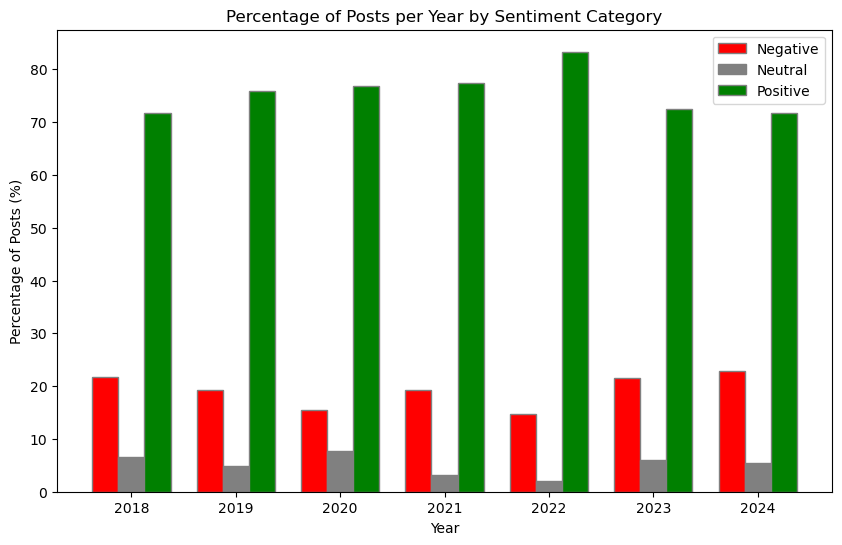

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.25
years = pivot_df_percent.index
r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars for each sentiment category
ax.bar(r1, pivot_df_percent['Negative'], color='red', width=bar_width, edgecolor='grey', label='Negative')
ax.bar(r2, pivot_df_percent['Neutral'], color='grey', width=bar_width, edgecolor='grey', label='Neutral')
ax.bar(r3, pivot_df_percent['Positive'], color='green', width=bar_width, edgecolor='grey', label='Positive')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Posts (%)')
ax.set_title('Percentage of Posts per Year by Sentiment Category')
ax.set_xticks([r + bar_width for r in range(len(years))])
ax.set_xticklabels(years)
ax.legend()

plt.show()

Looking at the posts, positive posts make over 70% of all posts throughout the years. There also seem to be very little neutral posts. Considering these results, we cannot really speak of polarization. However most of time the comments on a post are a better indication of polarization. Because comments mean a discussion of a post. 

### Sentiment Analysis for Comments 

In [23]:
df_uniq_comments = df[(~df['clean_text'].isna())]

# Remove duplicate values from the 'clean_text' column 
df_uniq_comments = df_uniq_comments.drop_duplicates(subset=['clean_text'])
df_uniq_comments.count()

comment_id                    530317
score                         530317
self_text                     530317
subreddit                     530317
created_time                  530317
post_id                       530317
controversiality              530317
ups                           530317
downs                         530317
post_score                    530317
post_self_text                173070
post_title                    530317
post_upvote_ratio             530317
post_thumbs_ups               530317
post_total_awards_received    530317
post_created_time             530317
clean_text                    530317
clean_post_self_text          170719
clean_title                   530267
year                          530317
dtype: int64

In [24]:
# Keeping only comments to climate related_posts
pattern = '|'.join(re.escape(keyword) for keyword in key_words_list)

# Filter posts with comments that match any of the keywords
matching_posts = df_uniq_comments[df_uniq_comments['clean_post_self_text'].str.contains(pattern, case=False, na=False)]

# Count the filtered DataFrame
matching_posts.count()

comment_id                    91676
score                         91676
self_text                     91676
subreddit                     91676
created_time                  91676
post_id                       91676
controversiality              91676
ups                           91676
downs                         91676
post_score                    91676
post_self_text                91676
post_title                    91676
post_upvote_ratio             91676
post_thumbs_ups               91676
post_total_awards_received    91676
post_created_time             91676
clean_text                    91676
clean_post_self_text          91676
clean_title                   91666
year                          91676
dtype: int64

In [25]:
df_climate_comments = pd.DataFrame(matching_posts)
df_climate_comments

comment_id score  \
2         lds3yu1     1   
5         lds3tpc     1   
8         lds3hu9     1   
19        lds2hpd     1   
25        lds1s40     1   
...           ...   ...   
642955    e1axb0w     1   
642960    e11uxy4     5   
642962    e11gdq6     2   
642963    e11cx81     2   
642993    dzwuxst     2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self_text  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Because they are paid handsomely by fossil fuel interests to say such things.   
5                                                                                                                                                                                                                                                                                                                                                                                                         Thanks for raising this subject. I like this sub and spend quite a bit of time posting and commenting. I understand your thinking but have to say that I don't think the divisiveness is an issue as the subject is divi

In [26]:
df_climate_comments = df_climate_comments[~(df_climate_comments.subreddit == 'conspiracy')]
df_climate_comments.count()

comment_id                    91676
score                         91676
self_text                     91676
subreddit                     91676
created_time                  91676
post_id                       91676
controversiality              91676
ups                           91676
downs                         91676
post_score                    91676
post_self_text                91676
post_title                    91676
post_upvote_ratio             91676
post_thumbs_ups               91676
post_total_awards_received    91676
post_created_time             91676
clean_text                    91676
clean_post_self_text          91676
clean_title                   91666
year                          91676
dtype: int64

In [27]:
df_climate_comments['comment_sentiment'] = df_climate_comments['clean_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Assign category for each record
df_climate_comments['comment_sentiment_category'] = df_climate_comments['comment_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))     

# Count the occurrences of each sentiment category
sentiment_counts = df_climate_comments['comment_sentiment_category'].value_counts()
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Comment_Sentiment', 'Count']
sentiment_counts_df = sentiment_counts_df.sort_values(by='Count', ascending=False)
sentiment_counts_df 

Comment_Sentiment  Count
0          Positive  49828
1          Negative  23739
2           Neutral  18109

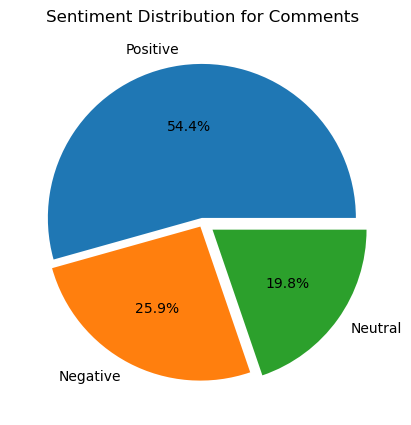

In [28]:
plt.figure(figsize=(5, 5))
ax = plt.pie(x = df_climate_comments['comment_sentiment_category'].value_counts() , labels=df_climate_comments['comment_sentiment_category'].value_counts().index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Sentiment Distribution for Comments')
plt.show()

Looking at the pie chart we see a more nuanced picture. While positive comments still dominate, the share of negative and neutral comments is bigger than for the posts. 

In [29]:
pd.set_option('display.max_colwidth', None)
print('Example of neutral comments') 
neutral_comments = df_climate_comments[df_climate_comments.comment_sentiment_category == 'Neutral']['self_text'].head(3)
display(neutral_comments.to_frame())

print('----------------------------------------------------------------')
print('Example of positive comments') 
positive_comments = df_climate_comments[df_climate_comments.comment_sentiment_category == 'Positive']['self_text'].head(3)
display(positive_comments.to_frame())

print('----------------------------------------------------------------')
print('Example of negative comments') 
pd.set_option('display.max_colwidth', None)
negative_comments = df_climate_comments[df_climate_comments.comment_sentiment_category == 'Negative']['self_text'].head(3)
negative_comments.to_frame()

Example of neutral comments


self_text
26                                                                                                                                                                                                                                                FTC- Lina khan isn’t letting anything through.
68                                                                                                                                                                                                                                                           Covid was what crashed the economy.
70  It does take investment, but oil has a proven track record for profit. The RNC wants to invest, but some people automatically believe they are against green energy because of this. Yes, the president absolutely can affect oil prices, and Biden imposing more regulations did affect it.

----------------------------------------------------------------
Example of positive comments


self_text
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Because they are paid handsomely by fossil fuel interests to say such things.
5   Thanks for raising this subject. I like this sub and spend quite a bit of time posting and commenting. I understand your thinking but have to say that I don't think the divisiveness is an issue as the subject is divisive. The issue I have is with the rational part of the byline. And even the rational part is good but so much of the discussion is not rational. I think maybe 90% of my responses here are spent discrediting misinformation posted by climate deniers. And even that I don't mind as it often results in my having to research the science where I learn something new. But the misinformation is repeated time after time in different replies which means time is wasted when it could be spent on actual rational discussions of actual climate science. There are some that post good information. Sometimes I get things wrong and the experts that post here correct the error and I learn something new then also. And one of the moderators seems to be very informed on climate science and will post good information. Those interactions and a good discussion are what keep me coming back but unfortunately it is not nearly often enough.
25                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   They don't believe that at all. They \*do\* believe that they can convince voters of it very easily, because they do, every time.

----------------------------------------------------------------
Example of negative comments


self_text
8   Getting politics involved has always been detrimental to science and engineering efforts. Technocrats made the argument that experts should make all of the decisions concerning projects within their area of expertise. But of course the communists say the same thing. So we're left with a system where non-professionals carry the weight of decision making.\n\nConsider the US space program. Political interests of spreading the wealth around pushed the cost of the Apollo program through the roof. The later space shuttle went from being a small personnel craft to a huge flying truck. Getting anything done is a compromise between science and politics,\n\nClimate was politicized nearly from the start. Without division we have no politics, Caring about science rather than politics is antithetical to most people since they base their decisions on emotions. Once the emotions are loosed there can be no compromise with science.
19                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Originally it seemed like they were just pandering to their base who lacked the education and curiosity to know the difference, however in the last few years it seems like they really do believe what they are saying.
31                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Some billionaires doubled their wealth during covid-in fact, wealth acquisition by the wealthiest people has increased higher than it ever has in history since covid began--they gathered things up while the rest of the world had to tough it out.

In [30]:
grouped_df = df_climate_comments.groupby(['year', 'comment_sentiment_category']).agg({'comment_id': 'count'}).reset_index()

pivot_df = grouped_df.pivot(index='year', columns='comment_sentiment_category', values='comment_id').fillna('')
print(pivot_df)

pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
np.round(pivot_df_percent, 2)

comment_sentiment_category  Negative  Neutral  Positive
year                                                   
2018                              68       46       235
2019                             148       93       447
2020                              27       19        98
2021                             196      126       547
2022                             449      385      1235
2023                            9270     7481     18600
2024                           13581     9959     28666


comment_sentiment_category  Negative  Neutral  Positive
year                                                   
2018                           19.48    13.18     67.34
2019                           21.51    13.52     64.97
2020                           18.75    13.19     68.06
2021                           22.55    14.50     62.95
2022                           21.70    18.61     59.69
2023                           26.22    21.16     52.62
2024                           26.01    19.08     54.91

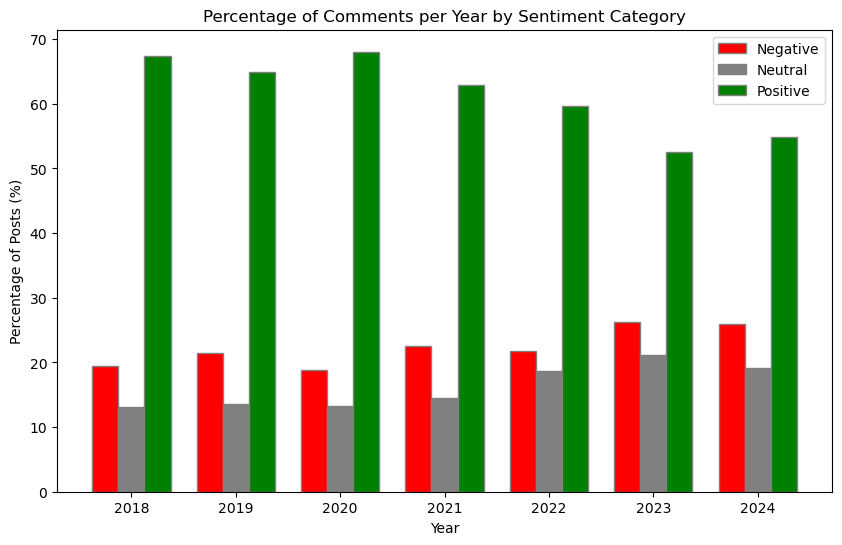

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.25
years = pivot_df_percent.index
r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars for each sentiment category
ax.bar(r1, pivot_df_percent['Negative'], color='red', width=bar_width, edgecolor='grey', label='Negative')
ax.bar(r2, pivot_df_percent['Neutral'], color='grey', width=bar_width, edgecolor='grey', label='Neutral')
ax.bar(r3, pivot_df_percent['Positive'], color='green', width=bar_width, edgecolor='grey', label='Positive')

# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Posts (%)')
ax.set_title('Percentage of Comments per Year by Sentiment Category')
ax.set_xticks([r + bar_width for r in range(len(years))])
ax.set_xticklabels(years)
ax.legend()

plt.show()

Over the years the percentage of positive comments decreases and the percentage of negative comments increases. While positive comments dominate throughout all of the years with a percentage above 50%, we can say that polarization increases. We can crosscheck this result by looking at the sentiment scores over time, i.e. the distribution of the sentiment scores and also at the controversiality of the comments.  

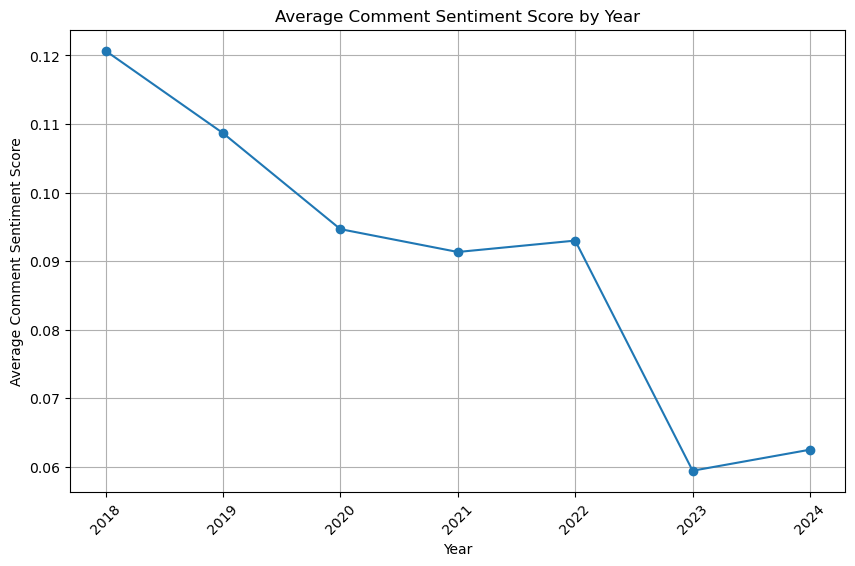

In [32]:
#sentiment scores over time 
grouped_score = df_climate_comments.groupby(['year']).agg({'comment_sentiment': 'mean'})
plt.figure(figsize=(10, 6))
plt.plot(grouped_score.index, grouped_score['comment_sentiment'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Comment Sentiment Score')
plt.title('Average Comment Sentiment Score by Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

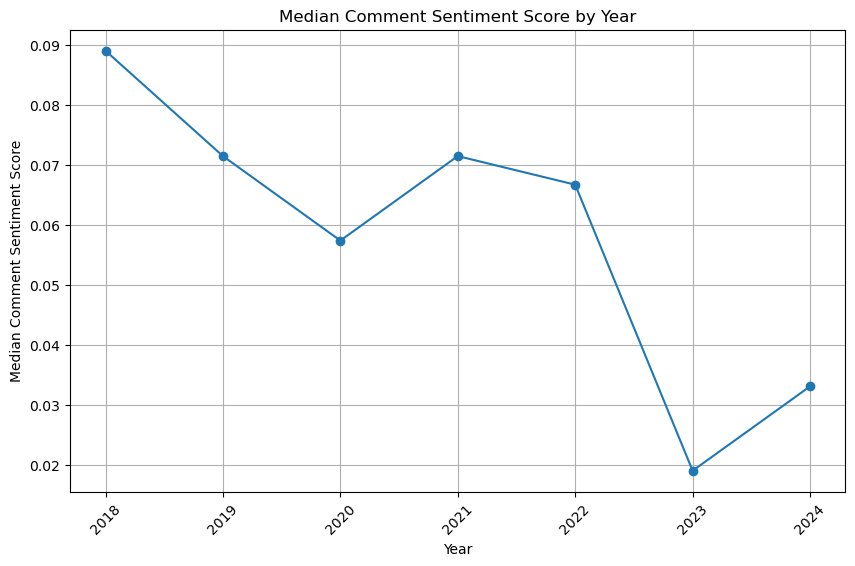

In [33]:
grouped_score = df_climate_comments.groupby(['year']).agg({'comment_sentiment': 'median'})
plt.figure(figsize=(10, 6))
plt.plot(grouped_score.index, grouped_score['comment_sentiment'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Median Comment Sentiment Score')
plt.title('Median Comment Sentiment Score by Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

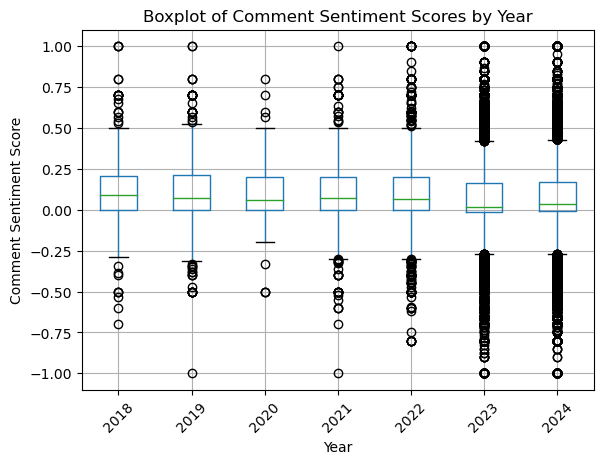

In [34]:
plt.figure(figsize=(10, 6))
df_climate_comments.boxplot(column='comment_sentiment', by='year', grid=True)

# Plot configuration
plt.xlabel('Year')
plt.ylabel('Comment Sentiment Score')
plt.title('Boxplot of Comment Sentiment Scores by Year')
plt.suptitle('')  # Remove the default title to avoid overlapping
plt.xticks(rotation=45)
plt.show()

We can see a lot more extreme values in 2023 and 2024. It might be an indication of increased polarization around climate change related topics because the outlier values have increased significantly over the last two years. 

But this effect might be also explained that we have simply more data for the last two years. Let's look at the distribution of comment_sentiment scores for the last two years over the month. 

In [35]:
df_climate_comments['month'] = pd.to_datetime(df_climate_comments['created_time']).dt.month
df_climate_comments['month']

2         7
5         7
8         7
19        7
25        7
         ..
642955    6
642960    6
642962    6
642963    6
642993    6
Name: month, Length: 91676, dtype: int64

In [36]:
grouped_months_2023_2024 = df_climate_comments[df_climate_comments.year.isin([2023,2024])].groupby(['year','month']).agg({'comment_id': 'count'})
grouped_months_2023_2024

comment_id
year month            
2023 1             273
     2             115
     3             164
     4              99
     5             413
     6              74
     7             782
     8            2948
     9            7938
     10           6513
     11           5729
     12          10303
2024 1            9281
     2            6950
     3            7129
     4            8156
     5            8363
     6            7729
     7            4598

<Figure size 1000x600 with 0 Axes>

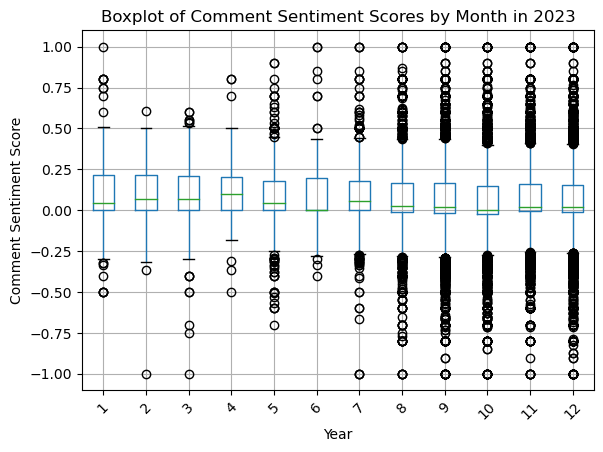

In [37]:
df_2023 = df_climate_comments[df_climate_comments.year == 2023]
plt.figure(figsize=(10, 6))
df_2023.boxplot(column='comment_sentiment', by='month', grid=True)

# Plot configuration
plt.xlabel('Year')
plt.ylabel('Comment Sentiment Score')
plt.title('Boxplot of Comment Sentiment Scores by Month in 2023')
plt.suptitle('')  # Remove the default title to avoid overlapping
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

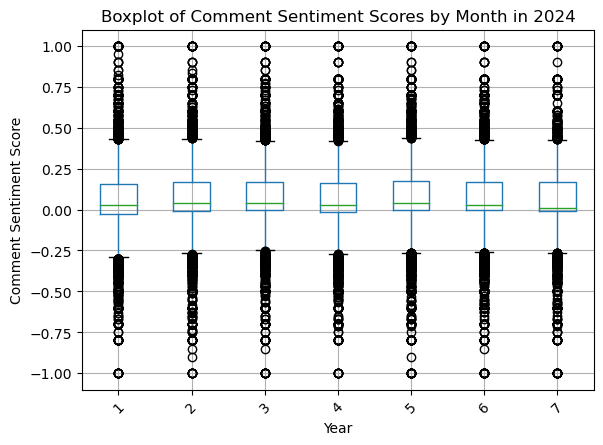

In [38]:
df_2024 = df_climate_comments[df_climate_comments.year == 2024]
plt.figure(figsize=(10, 6))
df_2024.boxplot(column='comment_sentiment', by='month', grid=True)

# Plot configuration
plt.xlabel('Year')
plt.ylabel('Comment Sentiment Score')
plt.title('Boxplot of Comment Sentiment Scores by Month in 2024')
plt.suptitle('')  # Remove the default title to avoid overlapping
plt.xticks(rotation=45)
plt.show()

We have a controversiality score for the comment. Let's look the distribution of the controversiality score and see if it matches the evolution of the sentiment score. 

controversiality is being recorded as a boolean value indicating whether or not a comment has received a similar amount of upvotes to downvotes, hence being controversial.

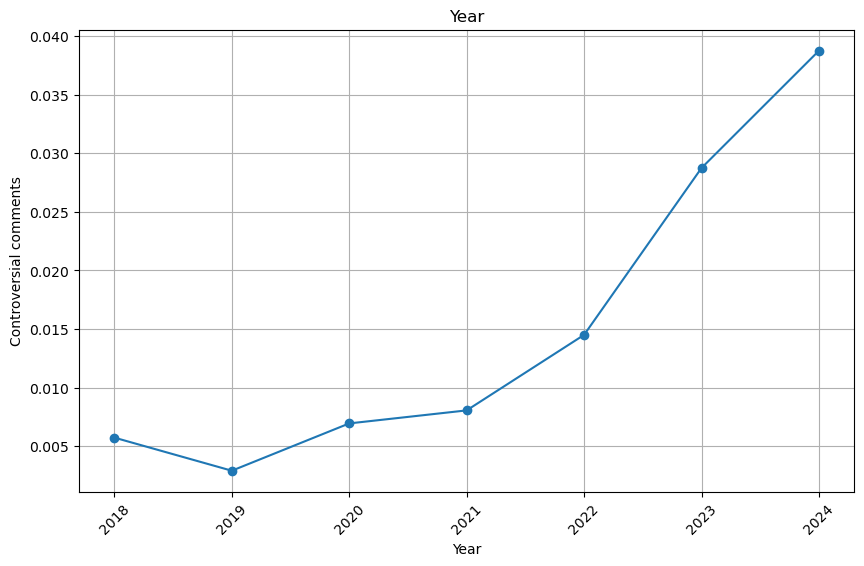

In [39]:
grouped_controversial = df_climate_comments.groupby(['year']).agg({'controversiality': 'mean'})
plt.figure(figsize=(10, 6))
plt.plot(grouped_controversial.index, grouped_controversial['controversiality'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Controversial comments')
plt.title('Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Looking at the mean controversiality score over several year, we see te same trend as in the destribution of the sentiment score. Towards 2023 and 2024 we see increased controversiality. Similarly we have more outlier sentiment scores indicating an increased polarization. 

## 2. Topic analysis for Titles, Posts and Comments

First let's look at what are the 10 most used words in all of our titles, posts and comments 

In [46]:
lemmatizer = WordNetLemmatizer()

In [67]:
#functions 

# Combine all text values into one large string
def join_all_words(df,column):
    df[column] = df[column].astype(str)
    all_words = ' '.join(df[column].tolist())
    return all_words

# Preprocess text 
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() ]
    filtered_words = [word for word in tokens]
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in filtered_words]
    return lemmatized_words

# Display and graph most frequent words all categories confounded
def display_graph_most_frequent_words(all_words):
    lemmatized_words = preprocess_text(all_words)

    # Count word frequencies
    word_freq = Counter(lemmatized_words)

    # Display the most common words
    most_common_words = word_freq.most_common(10)
    print("Most common words:", most_common_words)

    # Create a DataFrame for visualization
    word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

    # Plot the most common words
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq_df['word'], word_freq_df['frequency'], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Most Common Words in Text')
    plt.show()

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(lemmatized_words))

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Text')
    plt.show()

# Process each sentiment by category
def process_each_sentiment_by_category(df, str1, str2):
    for sentiment in df[str1].unique():
        subset = df[df[str1] == sentiment]
        all_words = ' '.join(subset[str2])
        words = preprocess_text(all_words)
        word_freq_by_sentiment[sentiment] = Counter(words)

# Display 10 most frequent words for each category
def display_10_most_freq_words(word_freq_by_sentiment):
    for sentiment, freq_counter in word_freq_by_sentiment.items():
        most_common_words = freq_counter.most_common(10)
        print(f"Most common words for {sentiment} sentiment:", most_common_words)

# Graph the most common words by sentiment 
def graph_most_freq_words_by_sentiment(word_freq_by_sentiment):
    for sentiment, freq_counter in word_freq_by_sentiment.items():
        most_common_words = freq_counter.most_common(10)
        print(f"Most common words for {sentiment} sentiment:", most_common_words)

        # Create a DataFrame for visualization
        word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

        # Plot the most common words
        plt.figure(figsize=(10, 6))
        plt.bar(word_freq_df['word'], word_freq_df['frequency'], color='skyblue')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.title(f'Most Common Words in {sentiment} Text')
        plt.xticks(rotation=45)
        plt.show()

        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud of {sentiment} Text')
        plt.show()
    
def word_freq_by_category_specific_keywords(df,str1,str2,keywords):
    for sentiment in df[str1].unique():
        subset = df[df[str1] == sentiment]
        all_words = ' '.join(subset[str2])
        words = preprocess_text(all_words)
        words = [word for word in words if word in keywords]
        word_freq_by_sentiment[sentiment] = Counter(words)
        word_freq_by_sentiment[sentiment]

    # Display the most common words by sentiment
    for sentiment, freq_counter in word_freq_by_sentiment.items():
        most_common_words = freq_counter.most_common(30)
        print(f"Most common words for {sentiment} sentiment:", most_common_words)

#### Analysis of Titles

Most common words: [('climate', 3992), ('change', 3030), ('emission', 1192), ('energy', 1091), ('carbon', 869), ('global', 758), ('warm', 619), ('new', 544), ('gas', 432), ('u', 425)]


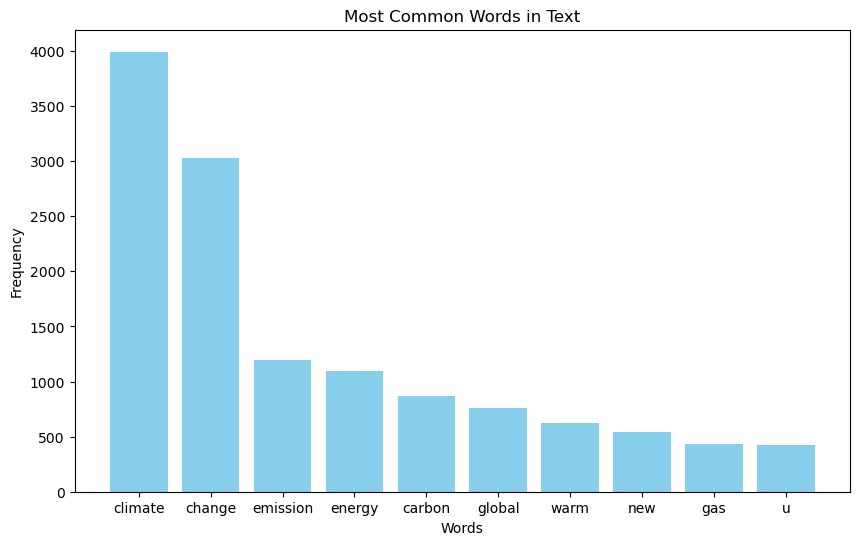

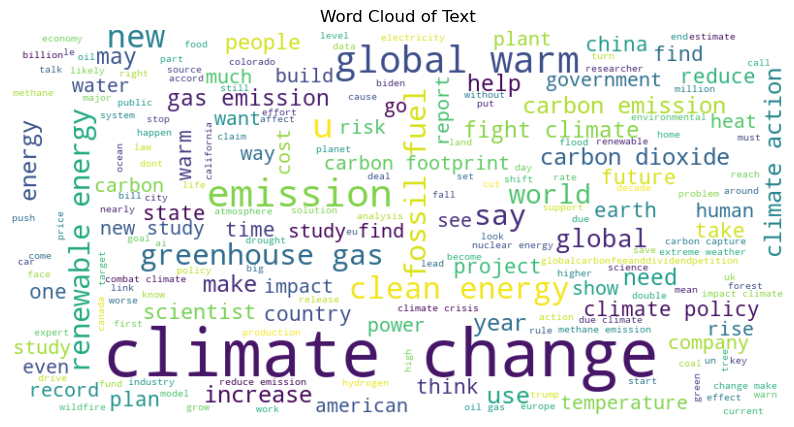

In [48]:
all_titles = join_all_words(df_climate_titles, 'clean_title')
display_graph_most_frequent_words(all_titles)

Not suprisingly the most frequent words are likled to climate keywords. Let's do the same analysis but segmenting the titles by sentiment category 

Most common words for Positive sentiment: [('climate', 1427), ('change', 955), ('energy', 594), ('emission', 479), ('new', 474), ('carbon', 366), ('global', 322), ('clean', 320), ('warm', 271), ('action', 221)]


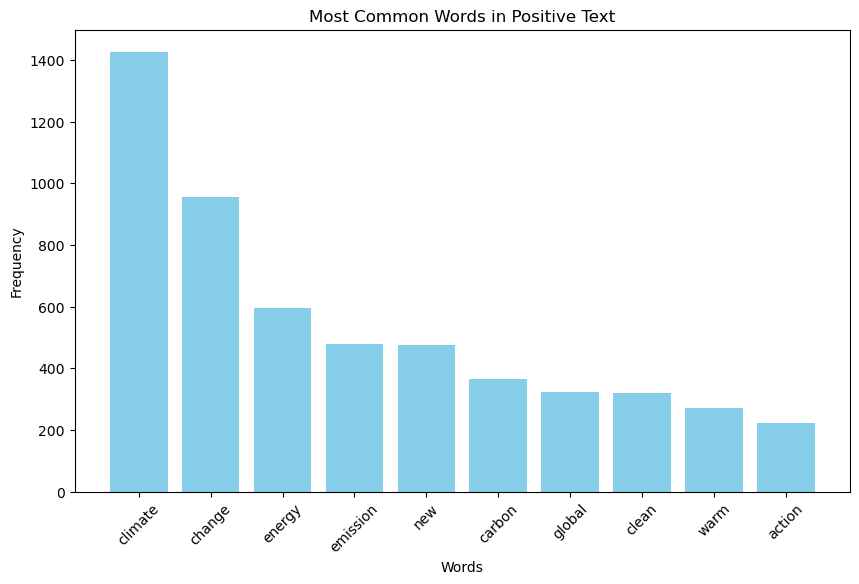

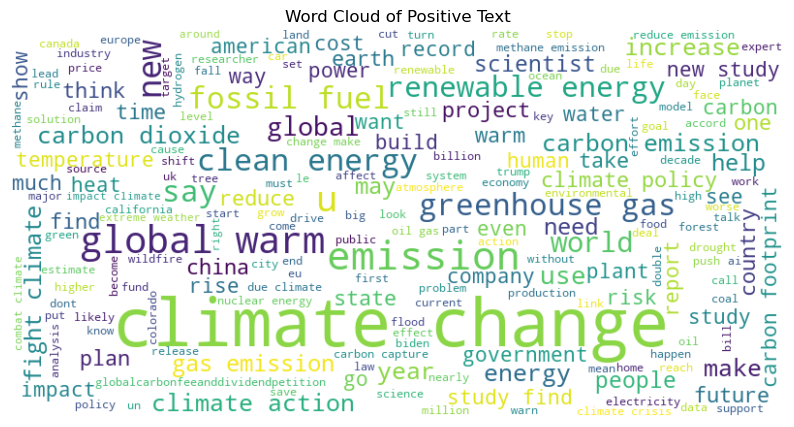

Most common words for Neutral sentiment: [('climate', 1695), ('change', 1379), ('emission', 488), ('energy', 363), ('carbon', 356), ('global', 280), ('warm', 224), ('gas', 150), ('renewable', 149), ('u', 145)]


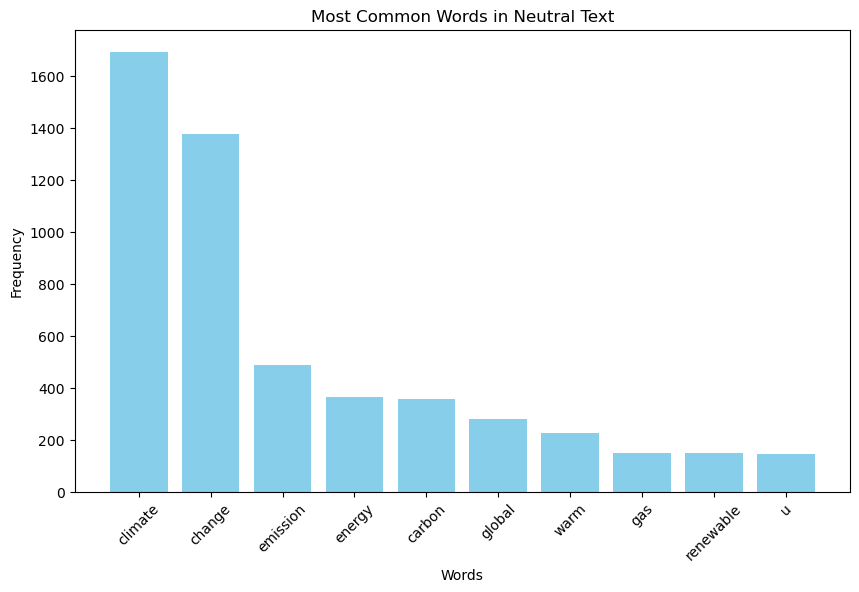

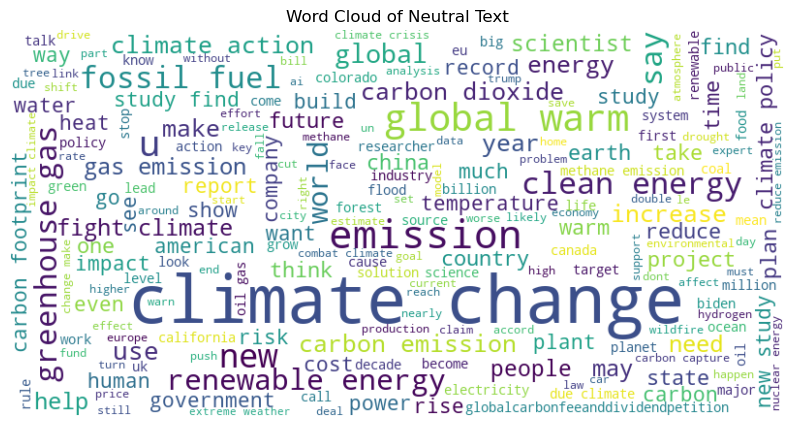

Most common words for Negative sentiment: [('climate', 870), ('change', 696), ('emission', 225), ('global', 156), ('carbon', 147), ('energy', 134), ('warm', 124), ('due', 99), ('say', 93), ('study', 92)]


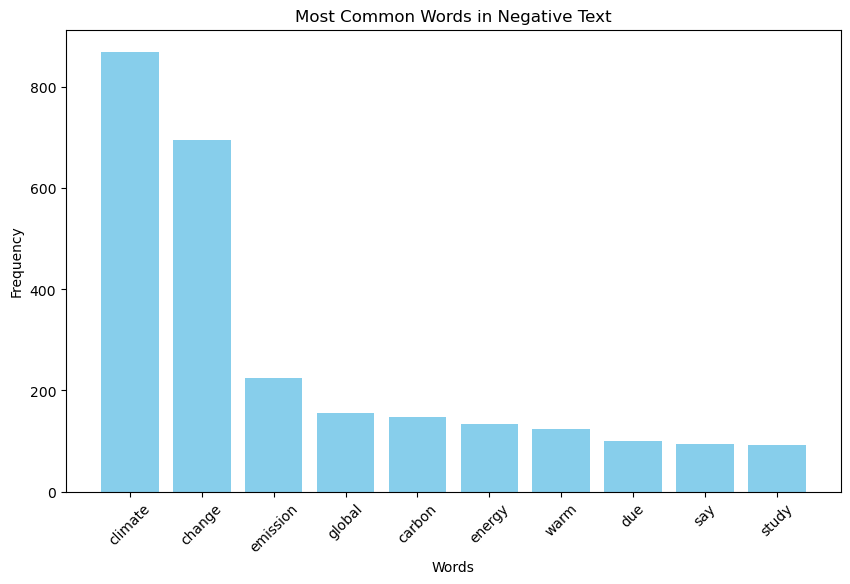

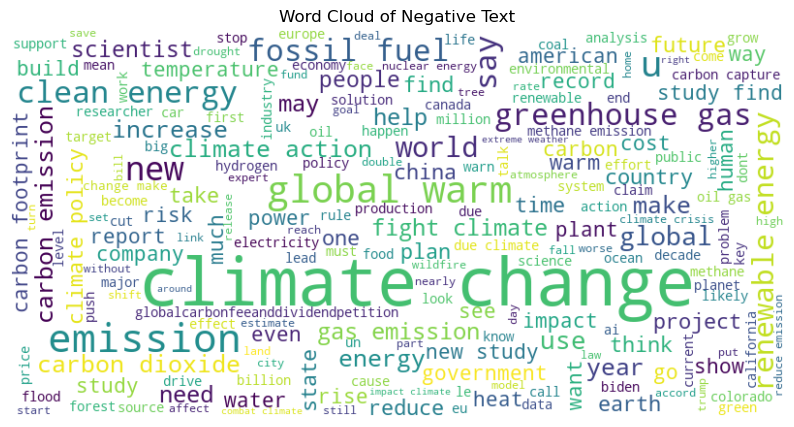

In [49]:
# Initialize a dictionary to hold word frequencies by sentiment
word_freq_by_sentiment = {sentiment: Counter() for sentiment in df_climate_titles['title_sentiment_category'].unique()}
# Process each sentiment category
process_each_sentiment_by_category(df_climate_titles, 'title_sentiment_category', 'clean_title')
# Graph most frequent words by category
words = preprocess_text(all_titles)
graph_most_freq_words_by_sentiment(word_freq_by_sentiment)

The analysis of the most frequent words across different title categories is not very conclusive. The words seems to be the more or less the same with climate being the most frequent words in all titles, followed by change. 

Let's do the same by specifically counting occurance of climate keywords from our list

In [68]:
# Process each sentiment category
word_freq_by_category_specific_keywords(df_climate_titles,'title_sentiment_category','clean_title',key_words_list)

Most common words for Negative sentiment: [('carbon', 147), ('energy', 134), ('footprint', 16), ('renewables', 13), ('resilience', 4), ('biofuels', 2), ('electrification', 1), ('urbanization', 1), ('charcoal', 1), ('photovoltaics', 1), ('biomass', 1)]
Most common words for Positive sentiment: [('energy', 594), ('carbon', 366), ('footprint', 37), ('renewables', 24), ('electrification', 11), ('biomass', 9), ('photovoltaics', 4), ('resilience', 2), ('charcoal', 1), ('photovoltaic', 1)]
Most common words for Neutral sentiment: [('energy', 363), ('carbon', 356), ('footprint', 44), ('renewables', 35), ('resilience', 15), ('biomass', 3), ('photovoltaic', 2), ('electrification', 1), ('biofuel', 1)]


Again we see that the three most frequent words are more or less the same for the positive, neutral and negative sentiments. 

Let's try to filter sentiments with respect to some locations that are typically mentioned a lot when talking about global climate change such as the US, the EU, BRICS etc. It won't be an exhaustive location list

In [69]:
location_list = ['us', 'usa', 'united states', 'america', 'eu', 'europe', 'european union', 'china', 'india', 'brazil', 'south africa', 'russia', 'brics']
word_freq_by_category_specific_keywords(df_climate_titles,'title_sentiment_category','clean_title', location_list)

Most common words for Negative sentiment: [('china', 14), ('india', 11), ('europe', 10), ('eu', 8), ('america', 7), ('russia', 5), ('brazil', 5), ('usa', 2)]
Most common words for Positive sentiment: [('china', 59), ('america', 30), ('europe', 24), ('eu', 16), ('india', 13), ('us', 8), ('russia', 6), ('usa', 4), ('brics', 1), ('brazil', 1)]
Most common words for Neutral sentiment: [('eu', 47), ('china', 46), ('europe', 26), ('india', 19), ('america', 13), ('russia', 7), ('brazil', 6), ('us', 5), ('usa', 2)]


Again we cannot really conclude any tendency. Let's look at the posts now. They contain more words and might show a clearer tendeny than the post titles which are just a headline. 

#### Analysis of Posts

Most common words: [('climate', 3790), ('change', 2764), ('energy', 1629), ('would', 1552), ('year', 1288), ('like', 1268), ('make', 1240), ('people', 1201), ('think', 1096), ('global', 1051)]


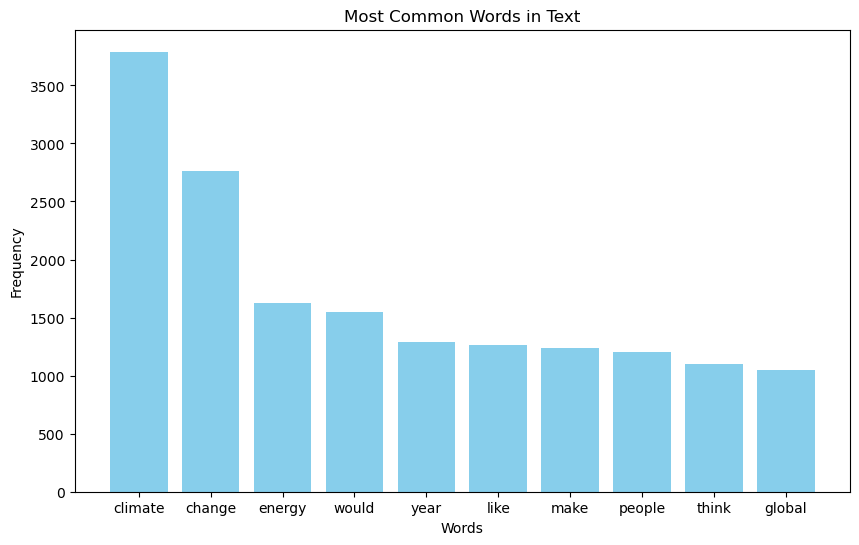

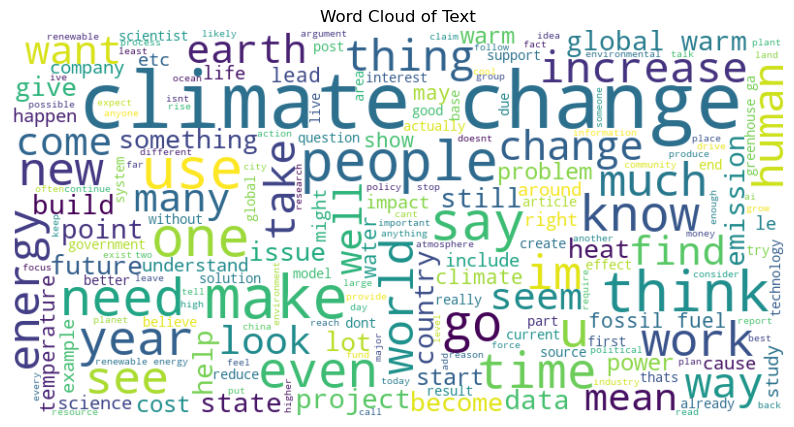

In [53]:
all_posts = join_all_words(df_climate_posts, 'clean_post_self_text')
display_graph_most_frequent_words(all_posts)

Most common words for Negative sentiment: [('climate', 720), ('change', 505), ('year', 235), ('like', 232), ('would', 221), ('people', 219), ('get', 214), ('energy', 208), ('make', 192), ('global', 190)]


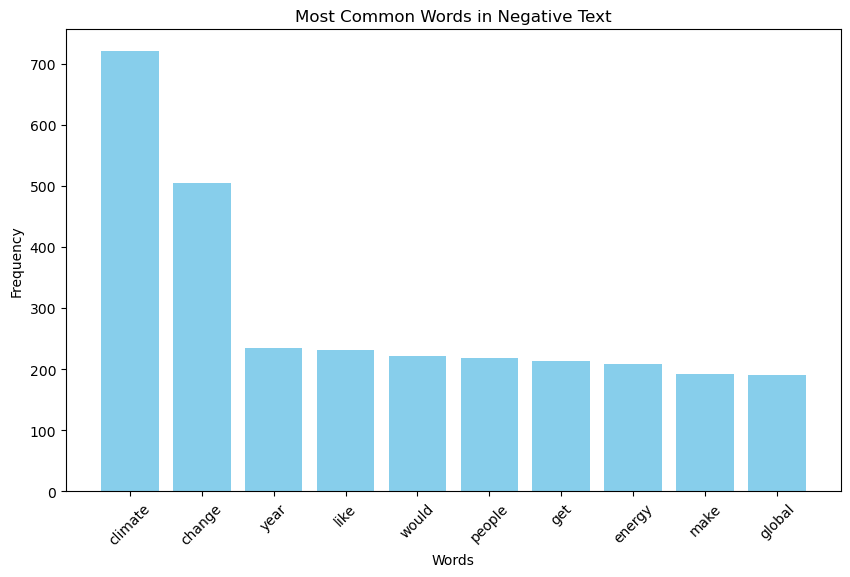

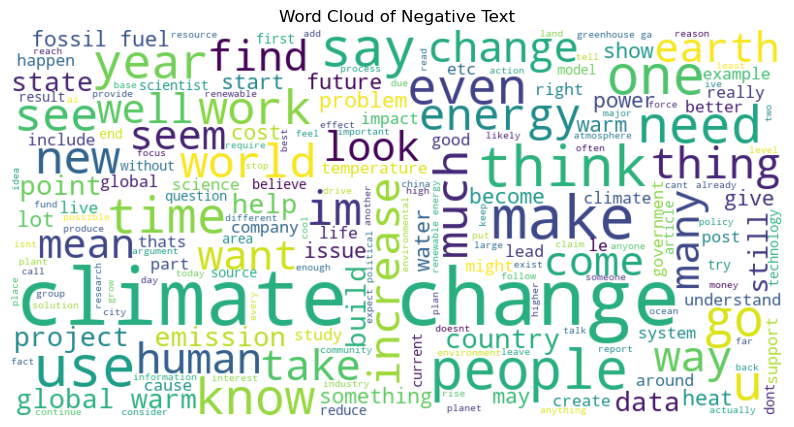

Most common words for Positive sentiment: [('climate', 2995), ('change', 2197), ('energy', 1396), ('would', 1320), ('year', 1038), ('make', 1036), ('like', 1021), ('people', 975), ('think', 898), ('use', 886)]


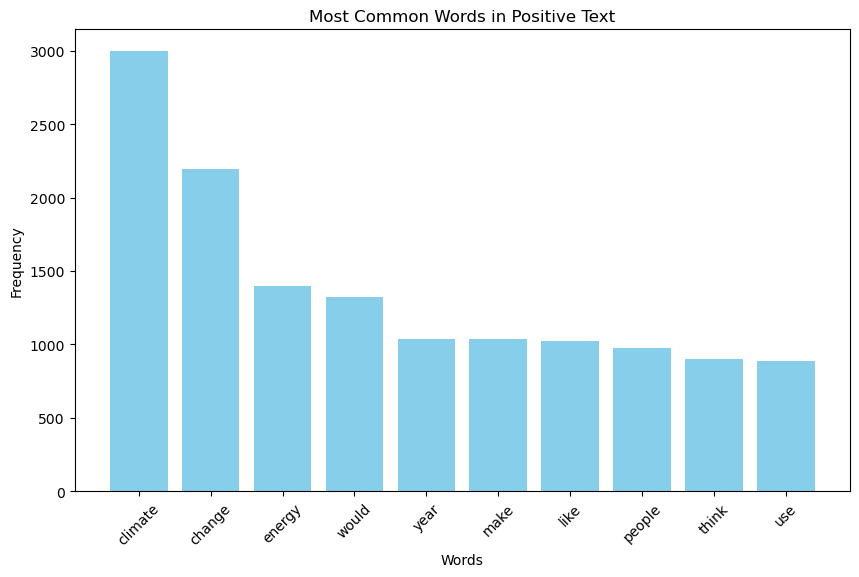

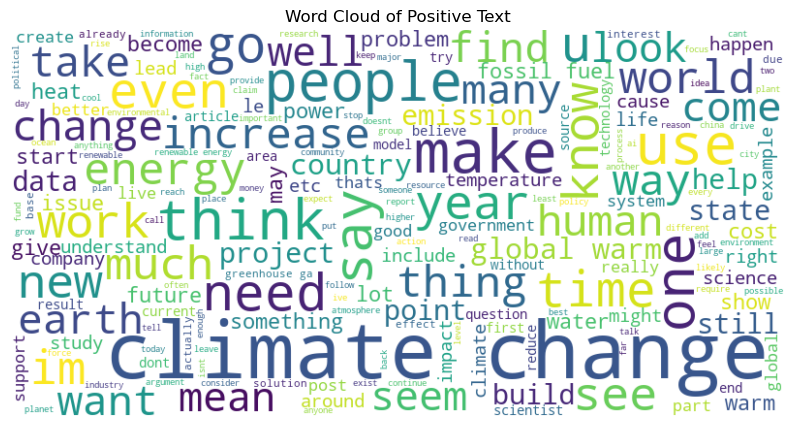

Most common words for Neutral sentiment: [('climate', 75), ('change', 62), ('carbon', 31), ('energy', 25), ('emission', 18), ('global', 16), ('year', 15), ('like', 15), ('warm', 15), ('make', 12)]


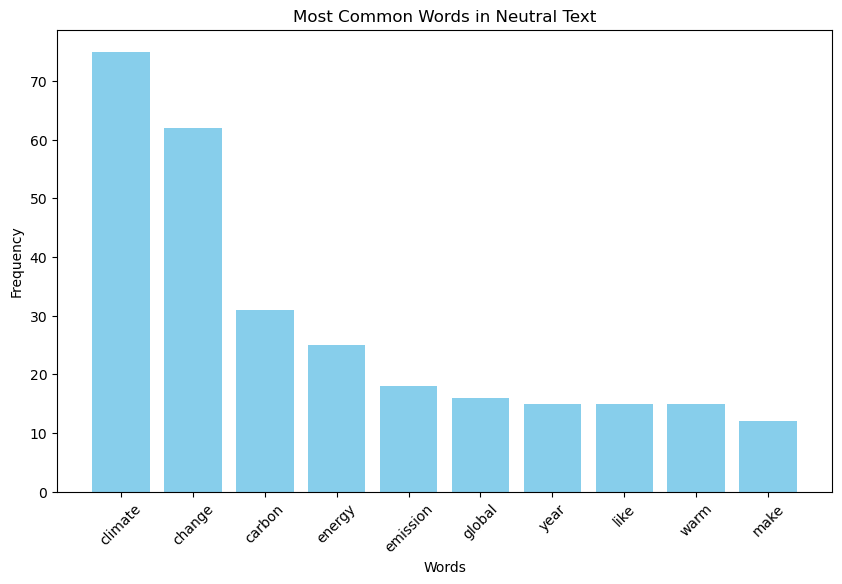

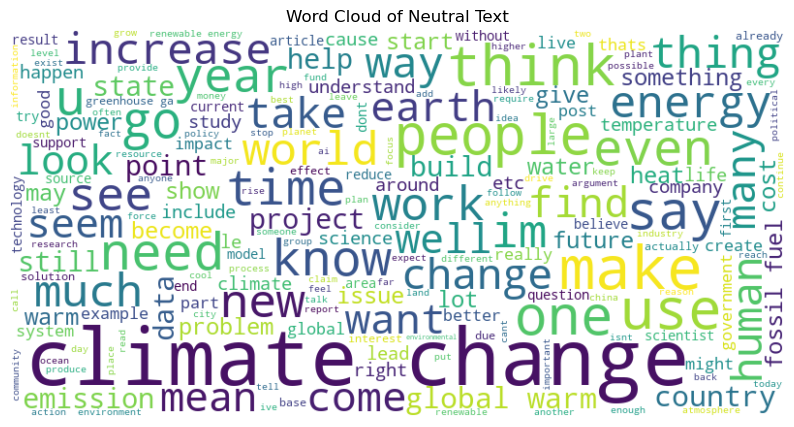

In [54]:
# Initialize a dictionary to hold word frequencies by sentiment
word_freq_by_sentiment = {sentiment: Counter() for sentiment in df_climate_posts['post_sentiment_category'].unique()}

# Process each sentiment category
process_each_sentiment_by_category(df_climate_posts, 'post_sentiment_category', 'clean_post_self_text')

# Graph most frequent words by category
words = preprocess_text(all_posts)
graph_most_freq_words_by_sentiment(word_freq_by_sentiment)

The trend for posts seems to be the same as for the title. The most used words are 'climate', followed by 'change' for all three sentiment categories. 

Some new words appeared such as year (in all three categories) or people (in positive and negative posts). However it is hard to make any sense of these words without knowing which year or which people. 

Let's do the same analysis as before with only the climate keywords and some locational key words. 

In [71]:
word_freq_by_category_specific_keywords(df_climate_posts,'post_sentiment_category','clean_post_self_text',key_words_list)

Most common words for Negative sentiment: [('energy', 208), ('carbon', 169), ('renewables', 35), ('footprint', 21), ('biomass', 5), ('resilience', 2), ('photovoltaic', 2), ('urbanization', 2), ('electrification', 1), ('biofuel', 1)]
Most common words for Positive sentiment: [('energy', 1396), ('carbon', 755), ('renewables', 116), ('footprint', 99), ('resilience', 28), ('biomass', 21), ('electrification', 17), ('photovoltaic', 11), ('urbanization', 4), ('bioenergy', 3), ('biofuel', 2), ('biofuels', 1), ('biodiesel', 1), ('unfcc', 1), ('photovoltaics', 1), ('charcoal', 1)]
Most common words for Neutral sentiment: [('carbon', 31), ('energy', 25), ('footprint', 4), ('renewables', 2)]


In [70]:
word_freq_by_category_specific_keywords(df_climate_posts,'post_sentiment_category','clean_post_self_text',location_list)

Most common words for Negative sentiment: [('china', 33), ('europe', 24), ('india', 13), ('america', 9), ('usa', 9), ('us', 9), ('eu', 6), ('russia', 5)]
Most common words for Positive sentiment: [('china', 231), ('america', 124), ('europe', 76), ('india', 62), ('russia', 53), ('us', 45), ('usa', 44), ('brazil', 36), ('eu', 33), ('brics', 1)]
Most common words for Neutral sentiment: [('europe', 2)]


Maybe not suprisingly, we see the same pattern as for the titles when it comes to the climate related key words. 

As for the location keywords, most suprisingly, only 'Europe is being mentioned'. The other countries are never mentioned. It might indicate increased polarization when it comes to post something related to these locations. But to be sure we have to look at the comments because usually the discussion happens in the comments. 

#### Analysis of Comments